In [52]:
%load_ext autoreload
%autoreload 2
import torch
import math
import random
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from mm.neural.neural import *
from layers import *
from network import *
from neural import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
initLogging("Common init")

dvc = torch.device("cpu")
log("device", dvc.type)

Common init:             -------------------------- 2023-07-31 12:44:42
device:                  cpu


In [54]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

ldr = loadData(filePath)
printDataInfo(ldr)

Prepare data:            -------------------------- 2023-07-31 12:44:42
filePath:                ../../data/names.txt
First few words:         ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Words counts:            32033
Vocabulary:              ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                    {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                    {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Vocabulary + end length: 27
random probability:      3.2958


In [55]:
logSection("Prepare dataset")

wordShufflingSeed = 42
log("Words shuffling seed", wordShufflingSeed)
random.seed(wordShufflingSeed)
random.shuffle(ldr.words)

contextSize = 3
log("Context size", contextSize)

ds = buildDataSet(ldr, contextSize, 0.8, 0.9, torch.int64, dvc)

Prepare dataset:         -------------------------- 2023-07-31 12:44:43
Words shuffling seed:    42
Context size:            3
Data dtype:              torch.int64
Training ratio:          0.8
Validation ratio:        0.9
Training:                length 25626 shape [182625, 3] ['yuheng', 'diondre', 'xavien']
Validation:              length 3203 shape [22655, 3] ['amay', 'aytana', 'jenevi']
Test:                    length 3204 shape [22866, 3] ['mustafa', 'reuben', 'kahlel']


In [56]:
logSection("Build network")

embeddingDims = 10
log("Embedding dimensions", embeddingDims)

hiddenLayerSize = 100
log("Hidden layers size", hiddenLayerSize)

learningSeed = 2147483647
log("Learning seed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

dtype = torch.float
log("dtype", dtype)

np = makeNetwork(g, len(ldr.stoi), embeddingDims, contextSize, hiddenLayerSize, dtype, dvc)
printNetworkInfo(np)
    
#@torch.no_grad()
def trLoss(): return getLoss(np, np.C[ds.tr.x], ds.tr.y)

#@torch.no_grad()
def valLoss(): return getLoss(np, np.C[ds.val.x], ds.val.y)

#@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[ds.tst.x], ds.tst.y)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:           -------------------------- 2023-07-31 12:44:43
Embedding dimensions:    10
Hidden layers size:      100
Learning seed:           2147483647
dtype:                   torch.float32
Network Layers Structure:
  Linear 35:             [30, 100]
  BatchNorm1d 36:        [100], [100]
  Tanh 37:               
  Linear 38:             [100, 100]
  BatchNorm1d 39:        [100], [100]
  Tanh 40:               
  Linear 41:             [100, 100]
  BatchNorm1d 42:        [100], [100]
  Tanh 43:               
  Linear 44:             [100, 100]
  BatchNorm1d 45:        [100], [100]
  Tanh 46:               
  Linear 47:             [100, 100]
  BatchNorm1d 48:        [100], [100]
  Tanh 49:               
  Linear 50:             [100, 27]
  BatchNorm1d 51:        [27], [27]
Parameters Count:        47024


Activations distribution - Linear
  Linear 35 [30, 100]:   mean: +0.00362, std: +0.18726, saturated: 0.00%
  Linear 38 [100, 100]:  mean: -0.00055, std: +0.09968, saturated: 0.00%
  Linear 41 [100, 100]:  mean: +0.00051, std: +0.10068, saturated: 0.00%
  Linear 44 [100, 100]:  mean: +0.00206, std: +0.10034, saturated: 0.00%
  Linear 47 [100, 100]:  mean: -0.00048, std: +0.10035, saturated: 0.00%
  Linear 50 [100, 27]:   mean: +0.00052, std: +0.09887, saturated: 0.00%
Plot:                    01 Activations distribution - Linear (12_44_44).png


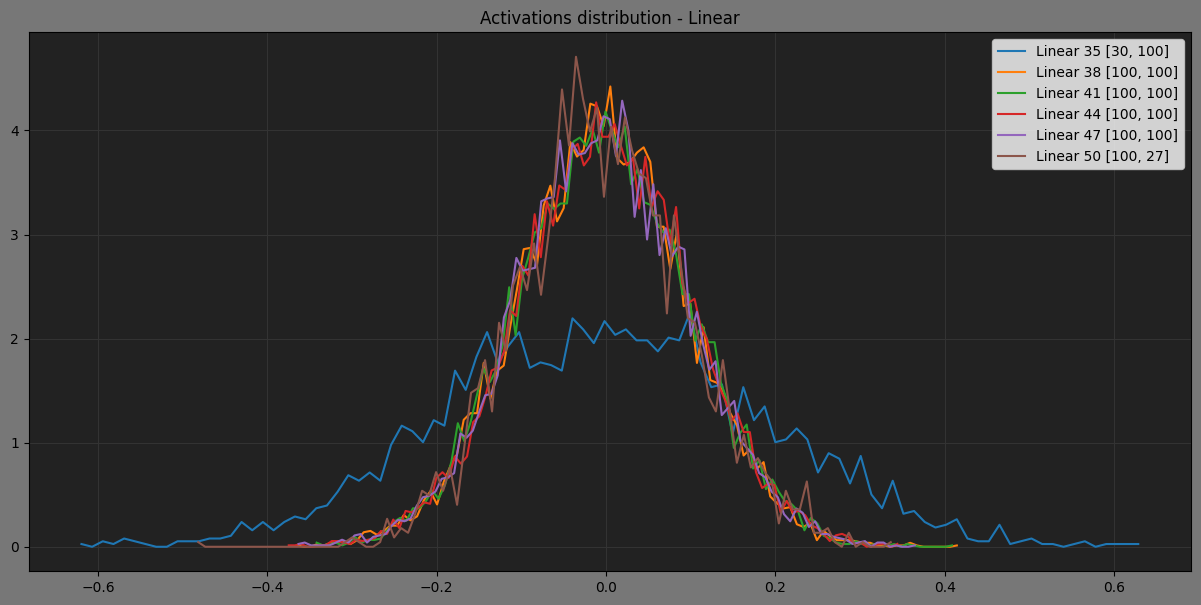

In [57]:
plotActivationsDistribution(Linear, np.layers)

In [58]:
logSection("Training")

trainingBatchSize = 32
log("Training batch size", trainingBatchSize)

trXLength = ds.tr.x.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("Training steps: ", trainingSteps)

repeats = 36
log("Repeats", repeats)

maxIteration = 1000
log("Max iterations", maxIteration)

maxLr = 0.15
log("Max learning rate", maxLr)

minLr = 0.001
log("Min learning rate", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("Actual iterations", actualIterations)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = True;

tsl = TrainingStatLists()
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
stopped = False
i = 0

for repeat in range(repeats):
    
    if stopped:
        break;

    logSimple(f"{repeat:>3}, {i:>7} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            stopped = True
            log("Stopped at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, ds.tr.x, ds.tr.y, miniBatchIxs)
        backwardPass(np.layers, np.parameters, fr.loss)
        up = updateNet(np.parameters, i, actualIterations, maxLr, minLr)
        
        if i == 0 or i % 100:
            tsl.step.append(i)
            tsl.forwardPassLoss.append(fr.loss.item())
            tsl.learningRate.append(up.learningRate)
            with torch.no_grad():
                vals1 = [((up.learningRate * not_null(p.grad)).std() / p.data.std()).log10().item() for p in np.parameters]
                tsl.gradToData.append(vals1)

        i += 1

logSimple(f"Final losses: {fr.loss.item():>17.4f}   ", end="")
#logLosses()

log("Embedding shape", fr.emb.shape)
log("Logits shape", fr.logits.shape)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = False;

Training:                -------------------------- 2023-07-31 12:44:44
Training batch size:     32
Training steps: :        5708
Repeats:                 36
Max iterations:          1000
Max learning rate:       0.15
Min learning rate:       0.001
Actual iterations:       1000
  0,       0 losses:     0.0000       3.3000     3.3010     3.3002
Stopped at max iteration:
Final losses:            2.3583   Embedding shape:         [32, 3, 10]
Logits shape:            [32, 27]


In [59]:
logSection("Introspection")

Introspection:           -------------------------- 2023-07-31 12:44:52


Max learning rate:       0.15
Min learning rate:       0.0011489999999999834
Plot:                    02 Learning rate progress (12_44_52).png


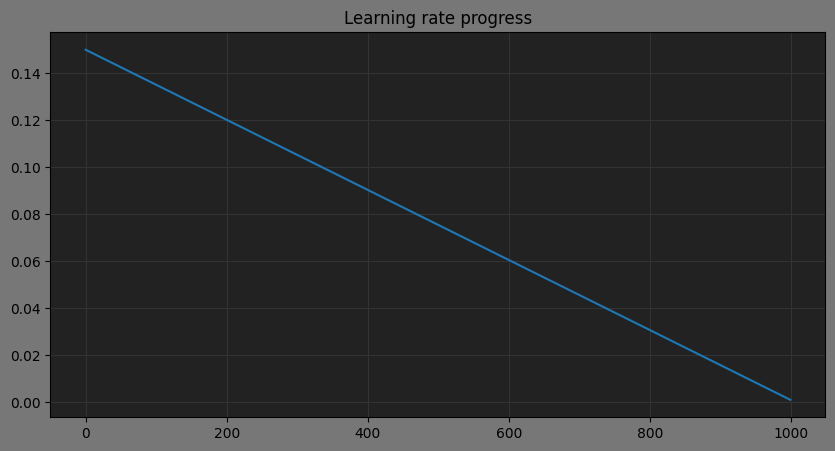

In [60]:
log("Max learning rate", max(tsl.learningRate))
log("Min learning rate", min(tsl.learningRate))
plotXY(tsl.step, tsl.learningRate, "Learning rate progress")

Activations distribution - Linear
  Linear 35 [30, 100]:   mean: +0.06124, std: +0.55438, saturated: 8.25%
  Linear 38 [100, 100]:  mean: +0.00038, std: +0.72271, saturated: 18.56%
  Linear 41 [100, 100]:  mean: +0.00286, std: +0.75812, saturated: 19.66%
  Linear 44 [100, 100]:  mean: -0.00523, std: +0.76538, saturated: 20.53%
  Linear 47 [100, 100]:  mean: -0.00152, std: +0.77072, saturated: 21.59%
  Linear 50 [100, 27]:   mean: +0.00533, std: +1.14028, saturated: 34.14%
Plot:                    03 Activations distribution - Linear (12_44_52).png


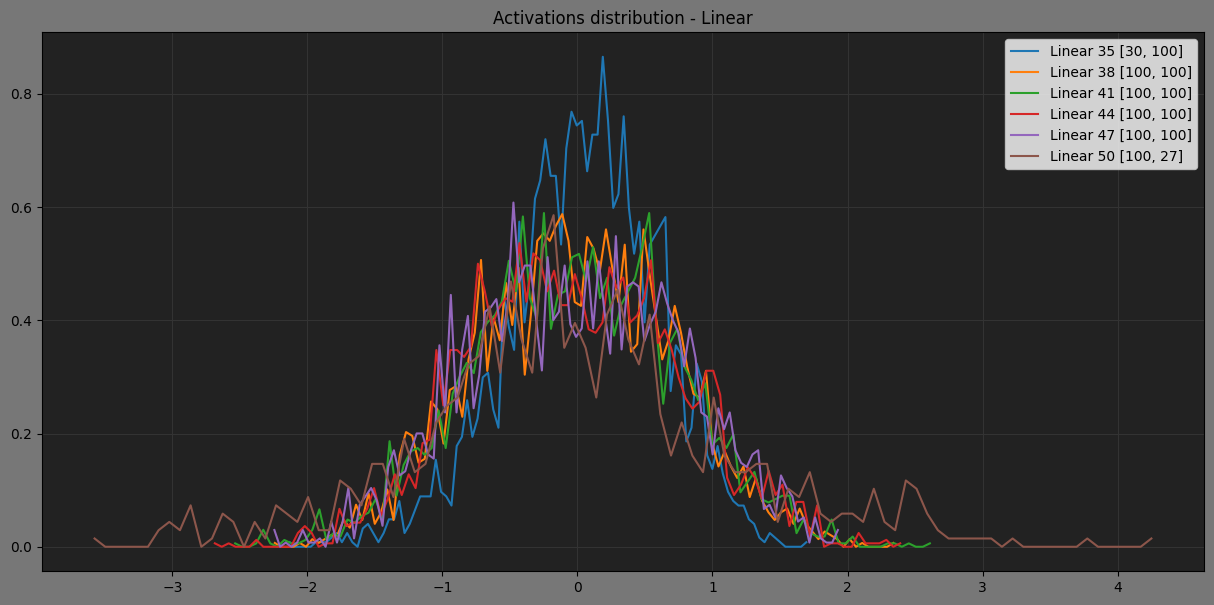

In [61]:
plotActivationsDistribution(Linear, np.layers)

Activations distribution - BatchNorm1d
  BatchNorm1d 36 [100], [100]: mean: -0.00010, std: +0.98438, saturated: 34.94%
  BatchNorm1d 39 [100], [100]: mean: +0.00011, std: +0.98557, saturated: 37.75%
  BatchNorm1d 42 [100], [100]: mean: +0.00049, std: +0.98638, saturated: 34.84%
  BatchNorm1d 45 [100], [100]: mean: -0.00099, std: +0.98639, saturated: 36.25%
  BatchNorm1d 48 [100], [100]: mean: +0.00046, std: +0.98534, saturated: 37.03%
  BatchNorm1d 51 [27], [27]: mean: +0.00000, std: +1.03448, saturated: 24.88%
Plot:                    04 Activations distribution - BatchNorm1d (12_44_53).png


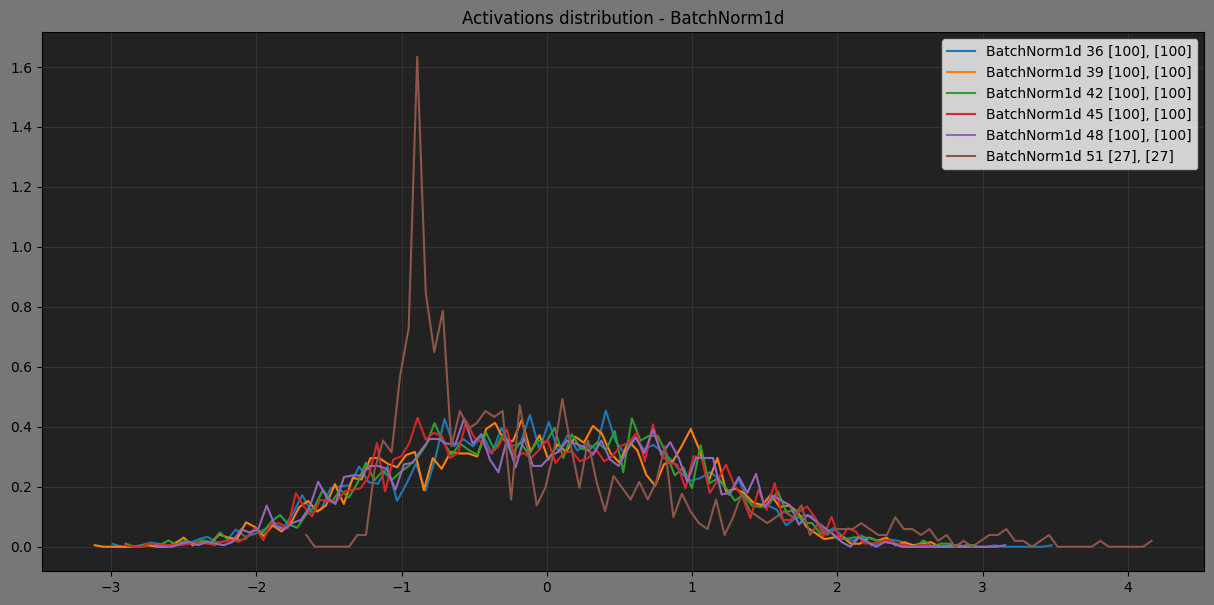

In [62]:
plotActivationsDistribution(BatchNorm1d, np.layers)

Activations distribution - Tanh
  Tanh 37:               mean: +0.00372, std: +0.63685, saturated: 2.34%
  Tanh 40:               mean: +0.00127, std: +0.64397, saturated: 1.97%
  Tanh 43:               mean: +0.00071, std: +0.64188, saturated: 2.44%
  Tanh 46:               mean: -0.00798, std: +0.65015, saturated: 1.69%
  Tanh 49:               mean: +0.00042, std: +0.65340, saturated: 1.06%
Plot:                    05 Activations distribution - Tanh (12_44_53).png


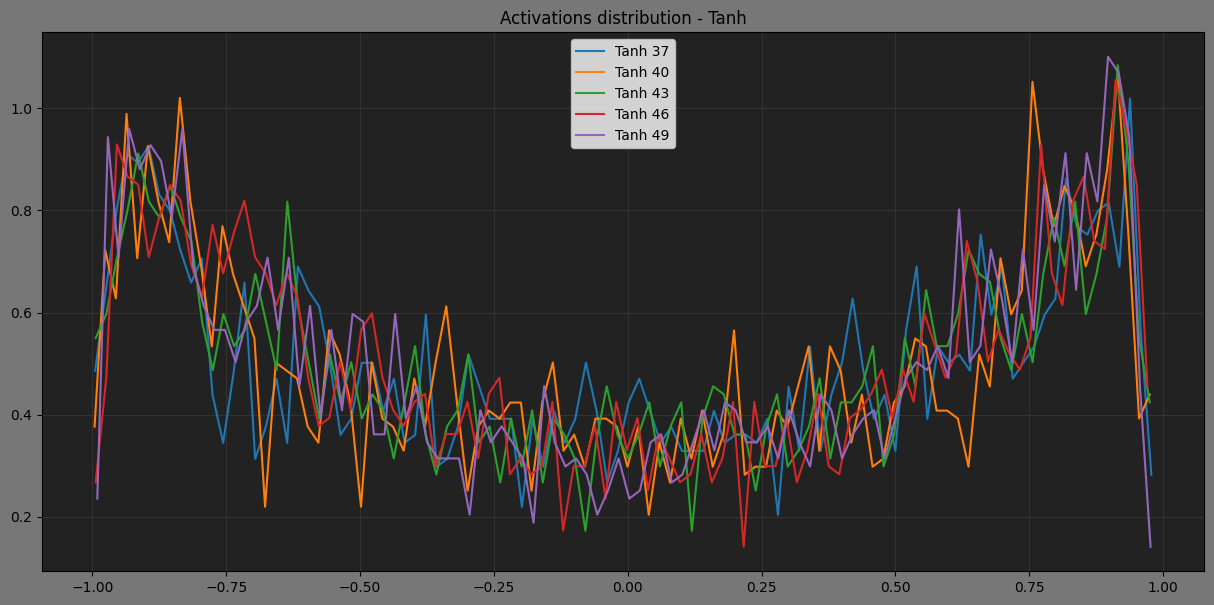

In [63]:
# for use without batch norm (lin with bias) std should be ~0.5 and sat ~5% 
plotActivationsDistribution(Tanh, np.layers)

Activations distribution - Linear (Grad)
  Linear 35 [30, 100]:   mean: +0.00000, std: +0.00656
  Linear 38 [100, 100]:  mean: +0.00000, std: +0.00225
  Linear 41 [100, 100]:  mean: -0.00000, std: +0.00201
  Linear 44 [100, 100]:  mean: +0.00000, std: +0.00180
  Linear 47 [100, 100]:  mean: +0.00000, std: +0.00175
  Linear 50 [100, 27]:   mean: +0.00000, std: +0.00357
Plot:                    06 Activations distribution - Linear (Grad) (12_44_54).png


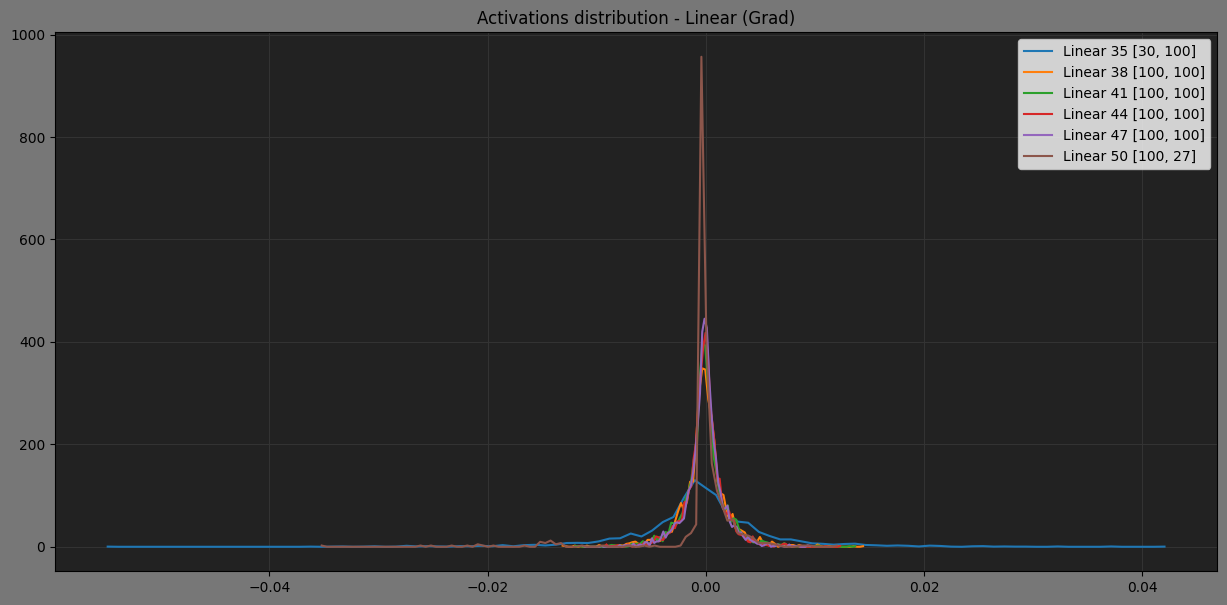

In [64]:
plotActivationsDistribution(Linear, np.layers, useGrad=True)

Activations distribution - BatchNorm1d (Grad)
  BatchNorm1d 36 [100], [100]: mean: -0.00001, std: +0.00177
  BatchNorm1d 39 [100], [100]: mean: -0.00002, std: +0.00151
  BatchNorm1d 42 [100], [100]: mean: +0.00001, std: +0.00142
  BatchNorm1d 45 [100], [100]: mean: -0.00001, std: +0.00131
  BatchNorm1d 48 [100], [100]: mean: +0.00001, std: +0.00128
  BatchNorm1d 51 [27], [27]: mean: -0.00000, std: +0.00545
Plot:                    07 Activations distribution - BatchNorm1d (Grad) (12_44_55).png


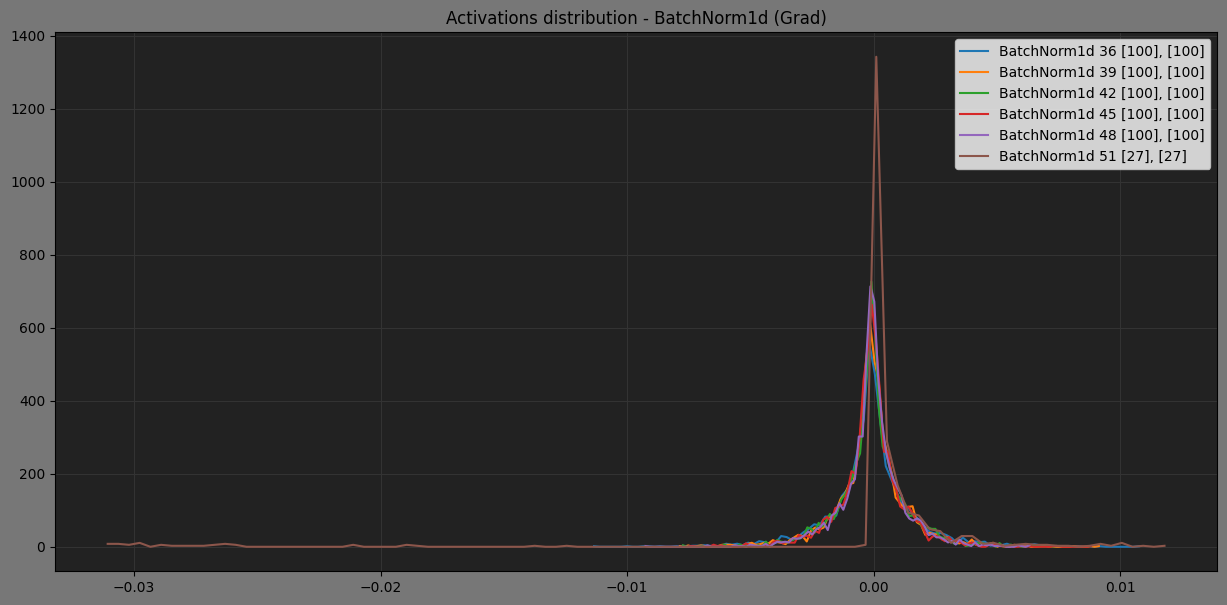

In [65]:
plotActivationsDistribution(BatchNorm1d, np.layers, useGrad=True)

Activations distribution - Tanh (Grad)
  Tanh 37:               mean: +0.00000, std: +0.00261
  Tanh 40:               mean: +0.00000, std: +0.00225
  Tanh 43:               mean: +0.00000, std: +0.00208
  Tanh 46:               mean: +0.00000, std: +0.00197
  Tanh 49:               mean: +0.00000, std: +0.00192
Plot:                    08 Activations distribution - Tanh (Grad) (12_44_55).png


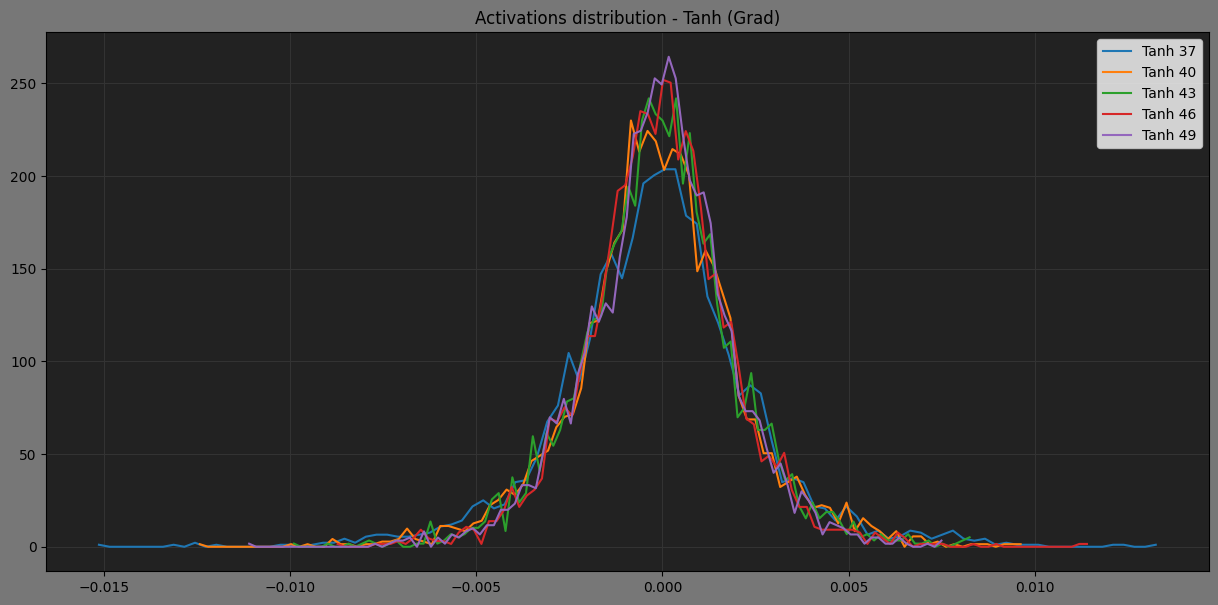

In [66]:
plotActivationsDistribution(Tanh, np.layers, useGrad=True)

Gradients weights distribution
  C:                        Weight   [27, 10], mean: -0.00000, std: 2.643839e-02, data ratio: 9.251904e-02
  Linear 35 [30, 100]:      Weight  [30, 100], mean: -0.00024, std: 9.849224e-03, data ratio: 5.225319e-02
  Linear 38 [100, 100]:     Weight [100, 100], mean: -0.00001, std: 7.533624e-03, data ratio: 7.456478e-02
  Linear 41 [100, 100]:     Weight [100, 100], mean: -0.00000, std: 6.722269e-03, data ratio: 6.610473e-02
  Linear 44 [100, 100]:     Weight [100, 100], mean: -0.00008, std: 6.139909e-03, data ratio: 6.071882e-02
  Linear 47 [100, 100]:     Weight [100, 100], mean: +0.00005, std: 6.142021e-03, data ratio: 6.076687e-02
  Linear 50 [100, 27]:      Weight  [100, 27], mean: -0.00004, std: 1.258991e-02, data ratio: 1.239018e-01
Plot:                    09 Gradients weights distribution (12_44_56).png


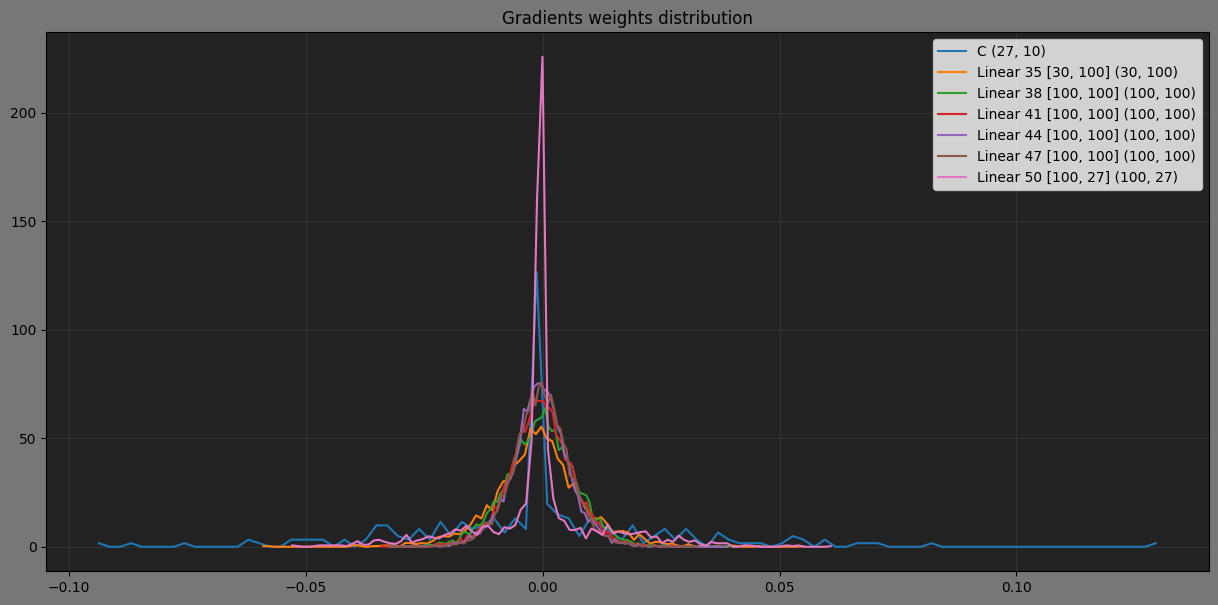

In [67]:
plotGradWeightsDistribution(Linear, np.C, np.layers)

Plot:                    10 (Log) Gradient update - Data ratio (12_44_56).png


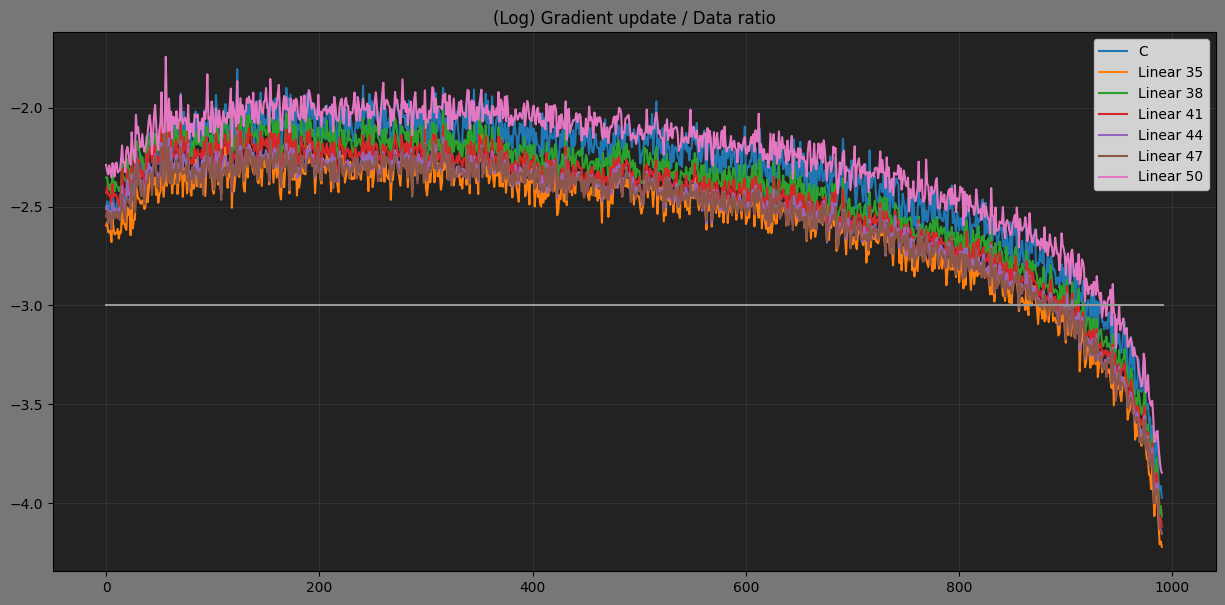

In [68]:
plotGradientUpdateRatio(tsl.gradToData, np.parameters, np.paramNames)

Plot:                    11 Learning rate - batch loss, per forward pass (12_44_57).png


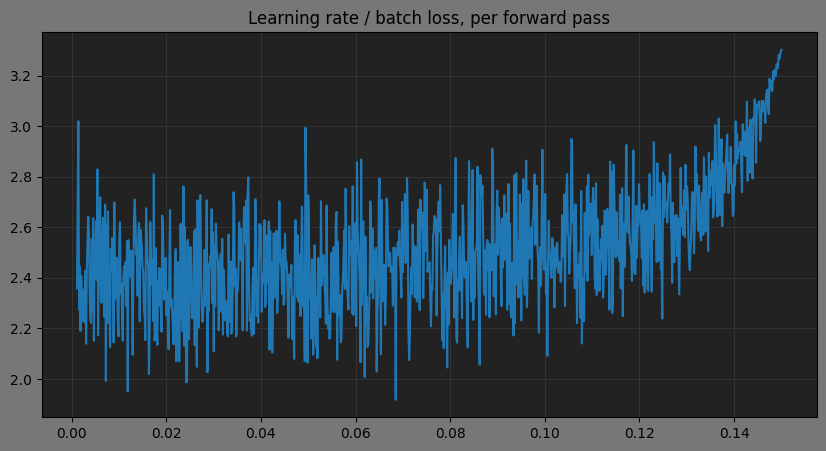

In [69]:
plotXY(tsl.learningRate, tsl.forwardPassLoss, "Learning rate / batch loss, per forward pass")

Plot:                    01. Learning batch loss per forward pass (12_46_26).png


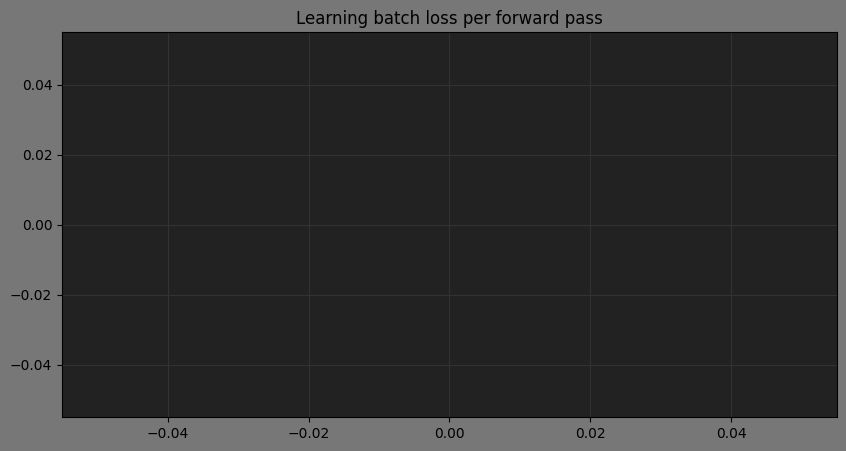

In [76]:
plotXY(tsl.step, tsl.forwardPassLoss, "Learning batch loss per forward pass")

Plot:                    13 Learning batch log-loss at training step (12_44_58).png


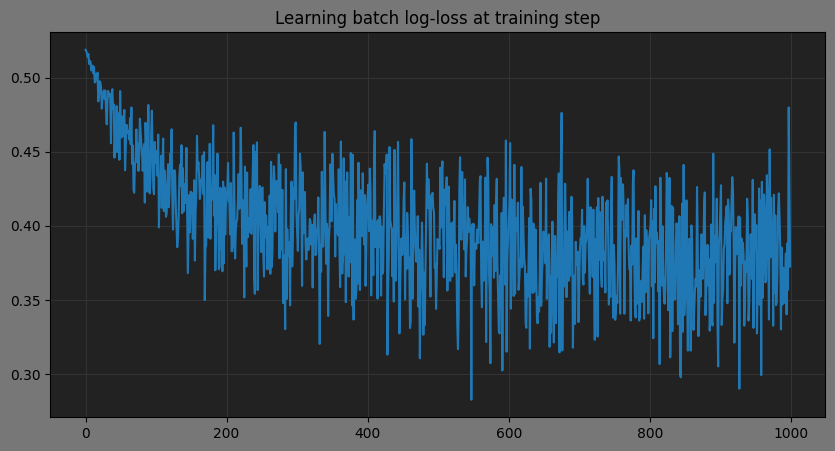

In [71]:
plotXY(tsl.step, [math.log10(x) for x in tsl.forwardPassLoss], "Learning batch log-loss at training step")

Plot:                    14 Embedding at [0, 1] (12_44_58).png


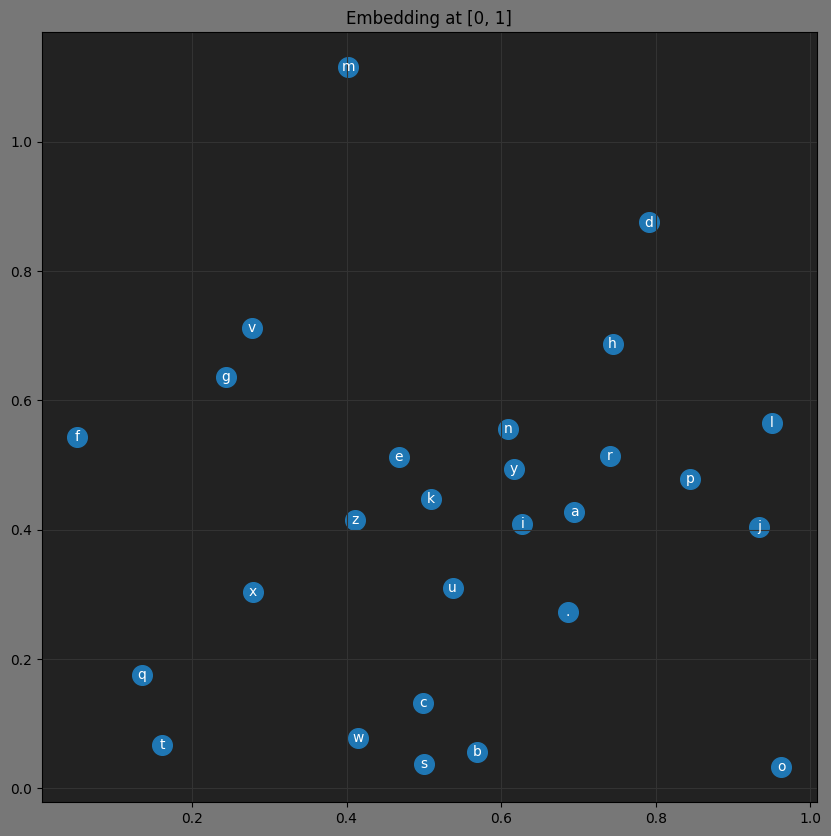

In [72]:
plotEmb(np.C, ldr.itos, 0)

In [73]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:                -------------------------- 2023-07-31 12:44:58
samplingSeed:            2147483657
maxSampleLength:         50


In [74]:
samples = sampleMany(np, gSampling, contextSize, ldr.itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

mria.                 102: 18 4 46 38 71 
kmyanniee.             96: 26 2 8 30 51 68 33 16 5 127 
med.                  113: 18 35 8 65 
ryah.                 113: 15 10 30 25 209 
rethan.               127: 15 45 10 56 81 84 62 
ejdrleg.               22: 11 3 3 7 8 62 3 91 
adered.               136: 34 12 42 24 21 3 80 
elin.                 156: 11 78 48 87 145 
shi.                  134: 17 79 18 26 
jelle.                198: 20 34 37 53 73 121 
eliean.                75: 11 78 48 18 8 60 95 
xar.                   33: 3 45 47 50 
kayzimh.              110: 26 117 21 4 36 6 10 146 
kalin.                330: 26 117 47 59 46 145 
shdbergihiane.         48: 17 79 2 1 62 30 4 44 1 11 87 76 12 95 
tri.                  120: 12 37 60 55 
jowelleqxn.            58: 20 29 3 42 52 54 73 1 2 5 153 
pacfiu.                11: 4 104 7 3 51 3 37 
zened.                 30: 7 33 41 17 3 75 
riyah.                151: 15 43 11 99 50 209 


In [75]:
logSection("Probabilities")

def printProb(txt: str):
    ps = calcProb(np, txt, contextSize, ldr.stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<25}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('carol.')
printProb('karol.')
printProb('karel.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('andrew.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')
printProb('x.')
printProb('xx.')
printProb('xxx.')
printProb('xxxx.')

Probabilities:           -------------------------- 2023-07-31 12:44:59
.                        96     : 3 
m.                       43     : 18 1 
mi.                      63     : 18 31 2 
mic.                     83     : 18 31 9 17 
mich.                    128    : 18 31 9 58 90 
micha.                   107    : 18 31 9 58 82 20 
michal.                  89     : 18 31 9 58 82 16 15 
michael.                 93     : 18 31 9 58 82 6 66 32 
michaela.                105    : 18 31 9 58 82 6 66 42 85 
michaella.               109    : 18 31 9 58 82 6 66 27 67 125 
michel.                  96     : 18 31 9 58 21 52 30 
carol.                   52     : 11 85 32 8 10 35 
karol.                   143    : 26 117 37 9 10 35 
karel.                   201    : 26 117 37 18 26 55 
martin.                  154    : 18 147 91 5 52 32 132 
andrej.                  152    : 34 28 20 17 63 2 96 
andrey.                  206    : 34 28 20 17 63 20 101 
andrew.                  143    : 34 28 20